Сделать venv

In [5]:
%pip install ngsolve
%pip install numpy
%pip install matplotlib
%pip install pandas
%pip install openpyxl

In [1]:
from ngsolve import *
from netgen.csg import *
from netgen.geom2d import SplineGeometry
import numpy as np
import matplotlib.pyplot as plt
from netgen.webgui import Draw as DrawGeo
import pandas as pd

In [2]:
import netgen.gui
%gui tk

Для простоты тестового расчета все размерности в м^3, чтоб не надо было приводить в безразмерный видч<br>
Из-за этого сам экспорт сетки в gmsh не имеет смысла<br>
Для экспорта надо поменять все на мм^3

In [6]:
def create_geometry():
    # Создание сфер с разными радиусами
    scalp = Sphere(Pnt(0, 0, 0), 98.0/10**3).mat("scalp").bc("scalp")
    skull = Sphere(Pnt(0, 0, 0), 93.0/10**3).mat("skull").bc("skull")
    csf = Sphere(Pnt(0, 0, 0), 88.0/10**3).mat("csf").bc("csf")
    surface_brain = Sphere(Pnt(0, 0, 0), 86.0/10**3).mat("surface_brain").bc("surface_brain")
    deep_brain = Sphere(Pnt(0, 0, 0), 69.0/10**3).mat("deep_brain").bc("deep_brain")

    # Вычитание сфер для создания вложенных структур
    geo = CSGeometry()
    geo.Add(scalp - skull)
    geo.Add(skull - csf)
    geo.Add(csf - surface_brain)
    geo.Add(surface_brain - deep_brain)
    geo.Add(deep_brain)
    
    # Генерация сетки
    ngmesh = geo.GenerateMesh(maxh=0.02)
    
    # Экспорт сетки в файл формата Gmsh
    ngmesh.Export("export.msh", "Gmsh Format")

    # Преобразование сетки в формат NGSolve
    return Mesh(ngmesh)

# Создание и визуализация геометрии
mesh = create_geometry()
Draw(mesh)
Redraw()

In [7]:
print(mesh.GetBoundaries())
print(mesh.GetMaterials())

('scalp', 'skull', 'csf', 'surface_brain', 'deep_brain')
('scalp', 'skull', 'csf', 'surface_brain', 'deep_brain')


In [8]:
T0 = Parameter(10.0)  # ambient temperature
h = 6  # Heat transfer coefficient (W/m²K)
region_densities = np.array([1000, 1500, 1003, 1050, 1050])  # density [kg/m^3]
p = CoefficientFunction(list(region_densities))
region_hcs = np.array([4000, 2300, 4174, 3700, 3700])  # specific heat capacity [J/K kg]
C = CoefficientFunction(list(region_hcs))
# Define range of thermal conductivities in the regions [W/m/k]
region_conductivities = np.array([0.34, 1.16, 0.618, 0.503, 0.503])
k = CoefficientFunction(list(region_conductivities))
k_test = CoefficientFunction(list(np.array([0.1, 0.1, 0.1, 0.1])))  # thermal conductivitie at the boundary
# Define range of specific heat capacities in the regions
region_losses = np.array([0, 0, 0, 0, 0])

# Initial value of solution
initial_value = 37.2  # [°C]

In [9]:
# H1-conforming finite element space
fes = H1(mesh, order=3, dirichlet="scalp|skull|csf|surface_brain|deep_brain")

# define trial- and test-functions
u = fes.TrialFunction()
v = fes.TestFunction()

# Solving the Poisson equation
f = LinearForm(fes)
f.Assemble()

a = BilinearForm(k * grad(u) * grad(v) * dx).Assemble()

gfu = GridFunction(fes)


In [10]:
gfuDir = GridFunction(fes)
gfuDir.Set(37.2, definedon=mesh.Boundaries("deep_brain"))
gfu.vec.data += gfuDir.vec

gfuDir = GridFunction(fes)
gfuDir.Set(35.5, definedon=mesh.Boundaries("surface_brain"))
gfu.vec.data += gfuDir.vec

gfuDir = GridFunction(fes)
gfuDir.Set(35, definedon=mesh.Boundaries("csf"))
gfu.vec.data += gfuDir.vec

gfuDir = GridFunction(fes)
gfuDir.Set(34, definedon=mesh.Boundaries("skull"))
gfu.vec.data += gfuDir.vec

gfuDir = GridFunction(fes)
gfuDir.Set(CoefficientFunction(31), definedon=mesh.Boundaries("scalp"))
gfu.vec.data += gfuDir.vec
Draw(gfu)

### для отладки

In [9]:
gfuDir = GridFunction(fes)
gfuDir.Set(37.2, definedon=mesh.Boundaries("deep_brain"))
gfu.vec.data += gfuDir.vec
Draw(gfu)

In [140]:
gfuDir = GridFunction(fes)
gfuDir.Set(35.5, definedon=mesh.Boundaries("surface_brain"))
gfu.vec.data += gfuDir.vec
Draw(gfu)


In [141]:
gfuDir = GridFunction(fes)
gfuDir.Set(35, definedon=mesh.Boundaries("csf"))
gfu.vec.data += gfuDir.vec
Draw(gfu)

In [142]:

gfuDir = GridFunction(fes)
gfuDir.Set(34, definedon=mesh.Boundaries("skull"))
gfu.vec.data += gfuDir.vec
Draw(gfu)


In [149]:
gfuDir = GridFunction(fes)
gfuDir.Set(CoefficientFunction(31), definedon=mesh.Boundaries("sсalp"))
gfu.vec.data += gfuDir.vec
Draw(gfu)

In [151]:
# Poisson dirichlet boundary conditions
gfu.Set(31, definedon=mesh.Boundaries("scalp"))
Draw(gfu)

In [130]:
gfu.Set(34, definedon=mesh.Boundaries("skull"))
Draw(gfu)

In [131]:
gfu.Set(35, definedon=mesh.Boundaries("csf"))
Draw(gfu)

In [132]:
gfu.Set(35.5, definedon=mesh.Boundaries("surface_brain"))
Draw(gfu)

In [133]:
gfu.Set(35.5, definedon=mesh.Boundaries("deep_brain"))
Draw(gfu)

### решение пуассона

In [11]:
r = f.vec.CreateVector()
r.data = f.vec - a.mat * gfu.vec
gfu.vec.data += a.mat.Inverse(freedofs=fes.FreeDofs()) * r

Draw(gfu)
Redraw()

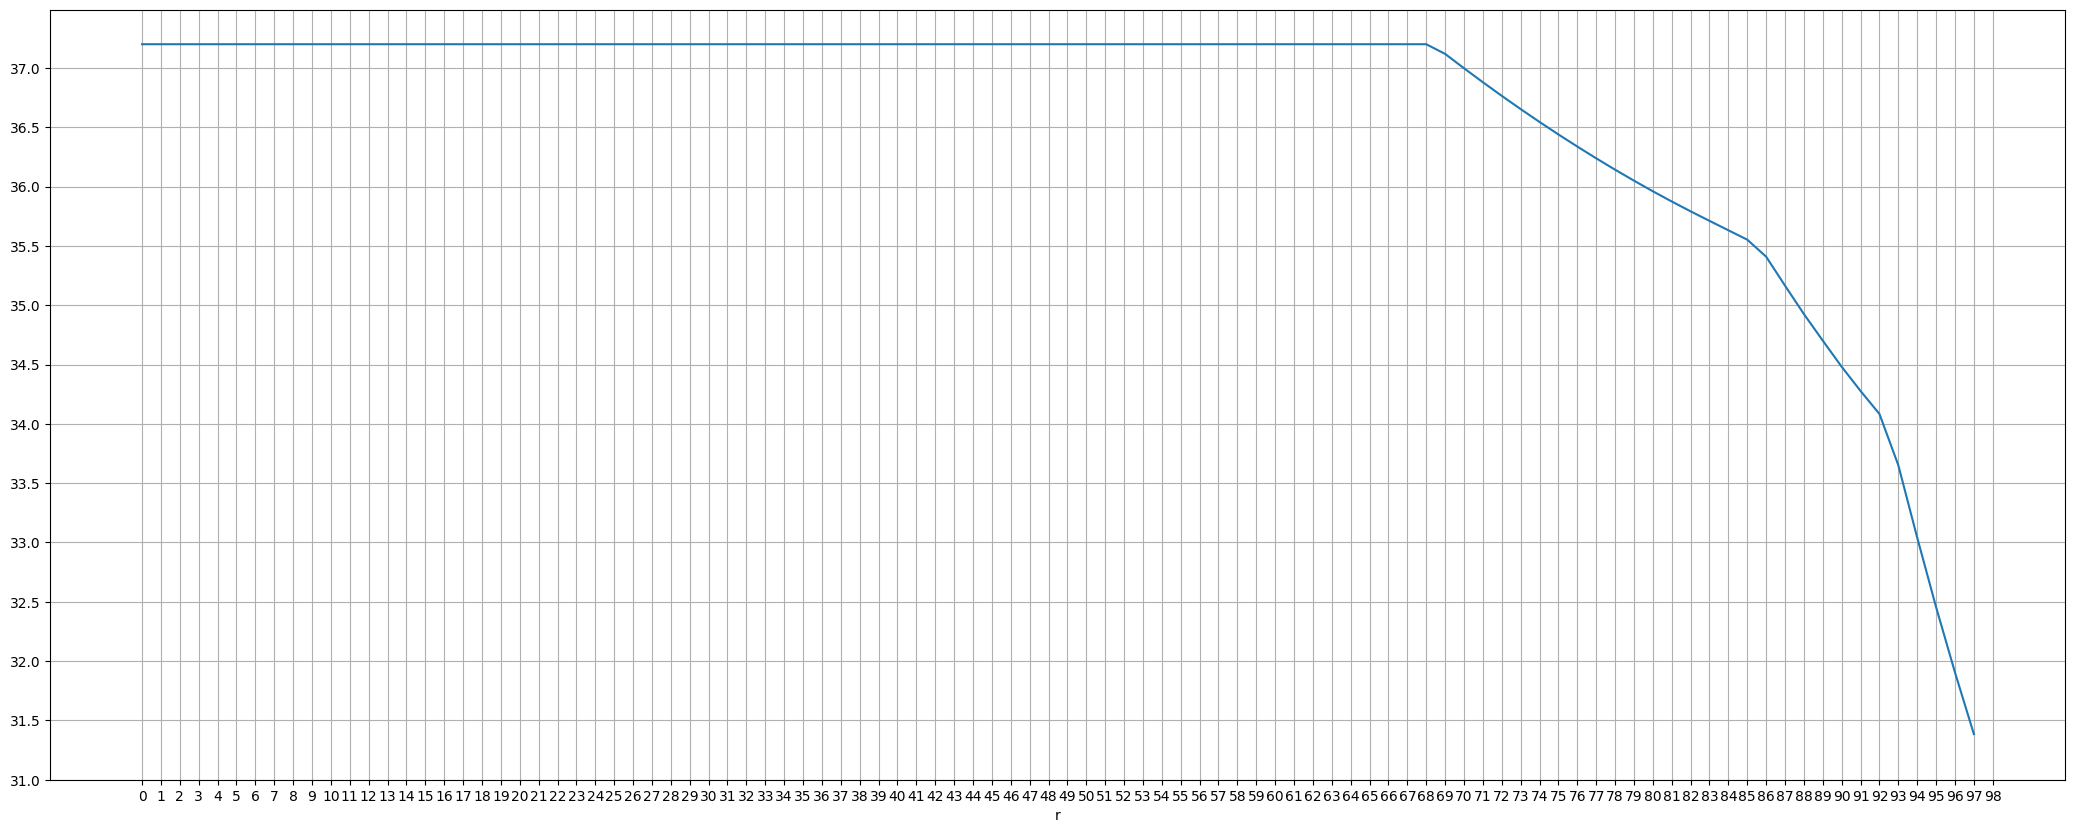

In [12]:
pts = []
vals = []

for r in range(0, 98):
    mip = mesh(r/10**3, 0, 0)
    pts.append(r)
    vals.append(gfu(mip))


plt.plot(pts, vals)
plt.xlabel('r')
plt.xticks(np.arange(0, (len(pts)+1), 1))
plt.yticks(np.arange(31, 37.2, 0.5))
plt.gcf().set_size_inches(26, 10)

#plt.yticks(np.arange(0, 37.5, 1))
#plt.xticks(np.arange(0, 1, 20))
plt.grid(True)
plt.show()

### Решение нестационарной задачи теплопроводности

In [13]:
# Solving a non-stationary problem, use Poisson equation solution as initial conditions
fes = H1(mesh, order=3)

u = fes.TrialFunction()  # symbolic object
v = fes.TestFunction()  # symbolic object

a = BilinearForm(k * grad(u) * grad(v) * dx)

a += h * u * v * ds(definedon=mesh.Boundaries('scalp'))
a.Assemble()

m = BilinearForm(fes, symmetric=False)
m += SymbolicBFI(C * p * u * v)
m.Assemble()

f = LinearForm(fes)
f += h * T0 * v * ds(definedon=mesh.Boundaries('scalp'))
f.Assemble()

dt = 60
t_end = 60 * 60 * 25
sources = 1
t = 0.0
snapshots = []

mstar = m.mat.CreateMatrix()
mstar.AsVector().data = m.mat.AsVector() + dt * a.mat.AsVector()
invmstar = mstar.Inverse(freedofs=fes.FreeDofs(), inverse="sparsecholesky")
res = gfu.vec.CreateVector()

mip = mesh(0, 0, 0)

Draw(gfu)
res = gfu.vec.CreateVector()
pts = []
vals = []
surf_vals = []

for j in range(int(t_end / dt)):
    res.data = f.vec - a.mat * gfu.vec
    gfu.vec.data += dt * invmstar * res
    print(j)
    pts.append(t / 60 / 60)
    vals.append(gfu(mip))
    surf_vals.append(gfu(mesh(97 / 10 ** 3, 0)))
    Redraw()
    t = round(t + dt, 6)

solution_vector = gfu.vec.FV().NumPy()[:]
print(surf_vals)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1          0
2        600
3       1200
4       1800
5       2400
       ...  
141    84000
142    84600
143    85200
144    85800
145    86400
Name: Êîîðäèíàòû òî÷êè: x = 0; y = 0, Length: 145, dtype: int64


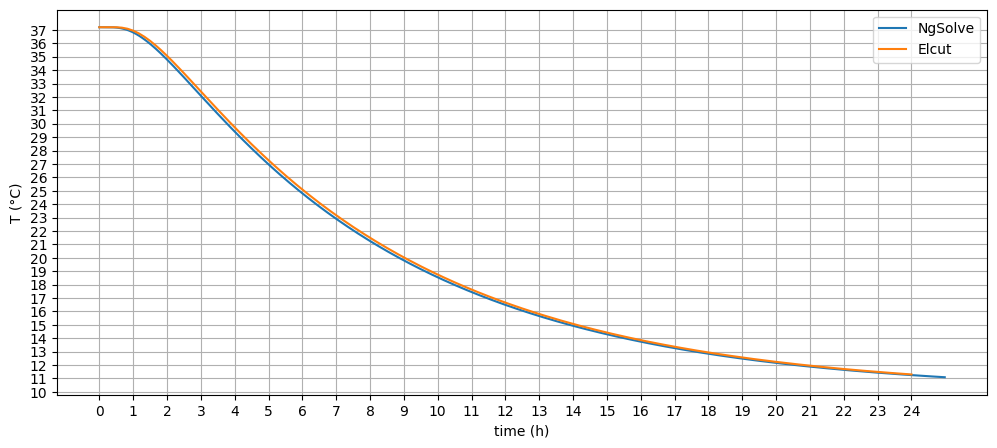

In [14]:
file_path = 'elcut_3d.xlsx'


sheet_name = '1'
columns_to_load = [0, 1]


df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=columns_to_load)
df = df.drop(0)
df = df.apply(pd.to_numeric, errors='coerce')


print(df.iloc[:,0])
plt.plot(pts, vals, df.iloc[:,0]/60/60, df.iloc[:,1])
plt.xlabel('time (h)')
plt.ylabel('T (°C)')
plt.legend(['NgSolve', 'Elcut'])
plt.yticks(np.arange(10, 37.5, 1))
plt.xticks(np.arange(0, 25, 1))
plt.grid(True)
plt.gcf().set_size_inches(12, 5)
plt.show()

In [15]:
def brain(K):
  return 8.425 * K

def rectum(k, Ta):
  if Ta < 23.3:
      return 8 * k
  return 10 * k

Ta = 10
T0 = 37.2
k = 0.127

import math
def tmp(t, k):
  #p = brain(k)
  p = 1.07
  #return Ta + (T0-Ta) * math.exp(-k * t) + k / (k - p) * (T0 - Ta) * (math.exp(-p*t) - math.exp(-k*t))
  return Ta + (T0-Ta) * (p/(p - k)* math.exp(-k * t) + k / (k - p) * math.exp(-p*t))

pts1 = []
vals1 = []
for i in range(25*5+1):
    pts1.append(i/5)
    vals1.append(tmp(i/5, k))

1          0
2        600
3       1200
4       1800
5       2400
       ...  
141    84000
142    84600
143    85200
144    85800
145    86400
Name: Êîîðäèíàòû òî÷êè: x = 0; y = 0, Length: 145, dtype: int64


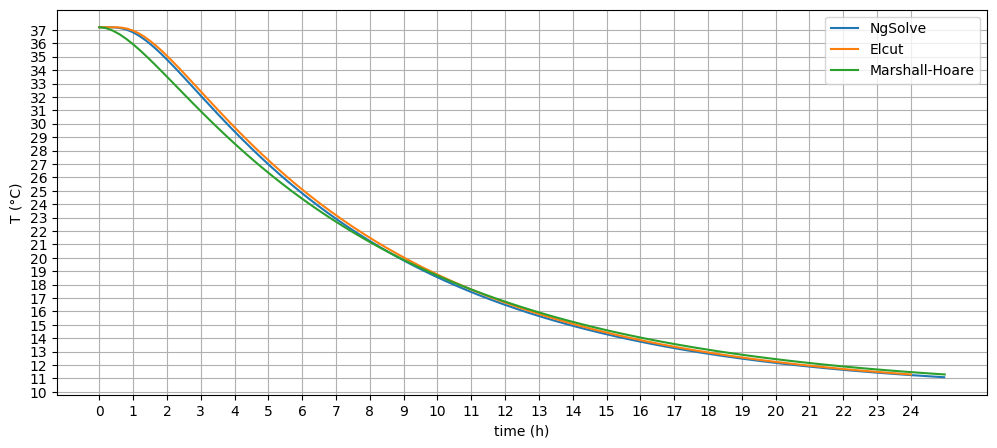

In [16]:
print(df.iloc[:,0])
plt.plot(pts, vals, df.iloc[:,0]/60/60, df.iloc[:,1], pts1, vals1)
plt.xlabel('time (h)')
plt.ylabel('T (°C)')
plt.legend(['NgSolve', 'Elcut', 'Marshall-Hoare'])
plt.yticks(np.arange(10, 37.5, 1))
plt.xticks(np.arange(0, 25, 1))
plt.grid(True)
plt.gcf().set_size_inches(12, 5)
plt.show()